# Using a Transformer to Predict NFL Player Movements

#### Preprocessing

##### Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

os.chdir('/content/drive/MyDrive/databowl/')
df = pd.read_csv('2023_tracking.csv')

In [3]:
play_ids = df['play_id_n'].unique()[2000:4500]
df = df[df['play_id_n'].isin(play_ids)]

In [ ]:
max_targets = df.groupby(['play_id_n', 'frame_id'])['player_to_predict'].sum().max()
print(max_targets)

8


##### Tabular to Pixel

In [ ]:
def pixel_map(player_data, target_player_ids, max_targets, grid_width=121, grid_height=55, sigma=.8):

    num_channels = 2 + max_targets + 1
    # three channels, one for offense, one for defense, one for ball location, one for player to predict
    pixel_map = np.zeros((num_channels, grid_height, grid_width), dtype=np.float32)

    x_vals = player_data['x'].values
    y_vals = player_data['y'].values

    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
        x_min = max(0, int(np.floor(x - 2*sigma)))
        x_max = min(grid_width, int(np.ceil(x + 2*sigma)) + 1)
        y_min = max(0, int(np.floor(y - 2*sigma)))
        y_max = min(grid_height, int(np.ceil(y + 2*sigma)) + 1)

        for xi in range(x_min, x_max):
            for yi in range(y_min, y_max):
                dist_sq = (xi - x)**2 + (yi - y)**2
                weight = np.exp(-dist_sq / (2 * sigma**2))

                player_id = player_data.iloc[i].get('nfl_id', None)

                if player_id in target_player_ids:
                    target_idx = target_player_ids.index(player_id)
                    if target_idx < max_targets: # to prevent error
                        pixel_map[2 + target_idx, yi, xi] += weight
                elif player_data.iloc[i]['player_side'] == 'Offense':
                    pixel_map[0, yi, xi] += weight
                elif player_data.iloc[i]['player_side'] == 'Defense':
                    pixel_map[1, yi, xi] += weight


    ball_x = player_data['ball_land_x'].iloc[0]
    ball_y = player_data['ball_land_y'].iloc[0]

    ball_x_min = max(0, int(np.floor(ball_x - 2*sigma)))
    ball_x_max = min(grid_width, int(np.ceil(ball_x + 2*sigma)) + 1)
    ball_y_min = max(0, int(np.floor(ball_y - 2*sigma)))
    ball_y_max = min(grid_height, int(np.ceil(ball_y + 2*sigma)) + 1)

    for xi in range(ball_x_min, ball_x_max):
        for yi in range(ball_y_min, ball_y_max):
            dist_sq = (xi - ball_x)**2 + (yi - ball_y)**2
            weight = np.exp(-dist_sq / (2 * sigma**2))
            pixel_map[2 + max_targets, yi, xi] += weight

    return pixel_map

testing one play

In [ ]:
df_play_id = df[df['play_id_n'] == 456]
target_player_ids = df_play_id[df_play_id['player_to_predict'] == True]['nfl_id'].unique().tolist()
df_grids_t = df_play_id.groupby(['play_id_n','frame_id']).apply(
    lambda x: pd.Series({'grid': pixel_map(x, target_player_ids, max_targets)})
)

C:\Users\dalto\AppData\Local\Temp\ipykernel_25552\2474093878.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grids_t = df_play_id.groupby(['play_id_n','frame_id']).apply(


grid for all plays

In [ ]:
df_grids = df.groupby(['play_id_n','frame_id']).apply(
    lambda x: pd.Series({'grid': pixel_map(x,  x[x['player_to_predict'] == True]['nfl_id'].unique().tolist(), max_targets)})
)

/tmp/ipython-input-3746108319.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grids = df.groupby(['play_id_n','frame_id']).apply(


In [ ]:
df_grids = df_grids.reset_index()
df_grids = df_grids.sort_values(['play_id_n', 'frame_id'])

visual test

In [ ]:
sample_grid = df_grids_t['grid'].iloc[30]

# Count how many target player channels have data
num_targets = 0
for i in range(max_targets):
    if sample_grid[2 + i].sum() > 0:
        num_targets += 1

# Create subplots: 2 base channels + ball + target players
total_plots = 3 + num_targets
cols = 4
rows = (total_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 5*rows))
axes = axes.flatten() if total_plots > 1 else [axes]

# Plot offense
axes[0].imshow(sample_grid[0], origin='lower', cmap='Reds')
axes[0].set_title('Offense Players')
axes[0].set_xlabel('X (yards)')
axes[0].set_ylabel('Y (yards)')

# Plot defense
axes[1].imshow(sample_grid[1], origin='lower', cmap='Blues')
axes[1].set_title('Defense Players')
axes[1].set_xlabel('X (yards)')
axes[1].set_ylabel('Y (yards)')

# Plot ball location (at index 2 + max_targets)
axes[2].imshow(sample_grid[2 + max_targets], origin='lower', cmap='Purples')
axes[2].set_title('Ball Landing Location')
axes[2].set_xlabel('X (yards)')
axes[2].set_ylabel('Y (yards)')

# Plot each target player (channels 2 through 2+max_targets-1)
plot_idx = 3
for i in range(max_targets):
    if sample_grid[2 + i].sum() > 0:
        axes[plot_idx].imshow(sample_grid[2 + i], origin='lower', cmap='Greens')
        axes[plot_idx].set_title(f'Target Player {i+1}')
        axes[plot_idx].set_xlabel('X (yards)')
        axes[plot_idx].set_ylabel('Y (yards)')
        plot_idx += 1

for idx in range(total_plots, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
df_grids.to_pickle("full_grids_2500.pkl")

### Transformer

##### Packages

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import gc
from transformers import get_cosine_schedule_with_warmup
df_grids = pd.read_pickle("full_grids_2500.pkl")
torch.manual_seed(26)

##### Inital Params

In [6]:
max_targets = int(df.groupby(['play_id_n', 'frame_id'])['player_to_predict'].sum().max())
max_input = int((df['frame_id'] - df['num_frames_output']).max())
max_output = int((df['num_frames_output']).max())
print(max_targets)
print(max_input)
print(max_output)

8
106
36


##### Time Encoded

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, dropout, max_length=150):
        super(PositionalEncoding, self).__init__()
        # droput
        self.dropout = nn.Dropout(p=dropout)

        # create matrix
        pe = torch.zeros(max_length, embed_size)

        # position tensor shape
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)

        # div_term tensor shape
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_size))

        # apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # apply cos to odd indices
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        # register as buffer so it moves with model to device
        self.register_buffer('pe', pe)

    def forward(self, x):
        pe_slice = self.pe[:x.size(1), :].to(x.device)
        x = x + pe_slice
        return self.dropout(x)

##### Player Positions

In [7]:
class PlayerPositionEmbedding(nn.Module):
    def __init__(self, embed_size, max_targets, num_positions = 17):
        super().__init__() # Added parentheses here
        self.embed_size = embed_size

        self.position_projection = nn.Embedding(num_positions, embed_size)
    def forward(self, player_positons, target_masks):
        # ints to learnable embedding space
        pos_embeds = self.position_projection(player_positons.long().squeeze(-1))

        # target mask, ignore padded values
        target_mask_expand = target_masks.unsqueeze(-1).expand_as(pos_embeds)
        pos_embeds = pos_embeds * target_mask_expand.float()

        return pos_embeds

##### Encoding

In [8]:
class CNN_DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # variable based on amount of targets
        input_chan = 2 + max_targets + 1

        # using stride rather than max pooling preforms better as max pooling tends to compress feat. too much.
        self.heatmap_encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_chan, out_channels=16, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU()

        )

    def forward(self, x):
        x = self.heatmap_encoder(x)
        return x


##### MHA

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead, mask, dropout=0.15):
        super().__init__() # inhert from parent class

        if d_model % nhead != 0:
            raise ValueError(f"d_model ({d_model}) must be divisible by nhead ({nhead})")

        self.d_model = d_model # dimension of model
        self.nhead = nhead # number of attention heads, multi headed
        self.head_dim = d_model // nhead

        # create key query and values
        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        # learn context as a product of the attention heads
        self.out_proj = nn.Linear(d_model, d_model)
        # dropout as a form of regularzation
        self.dropout = nn.Dropout(dropout)
        # scaling function
        self.scale = self.head_dim ** -0.5

    def forward(self, x, mask=None):
        B, L, _ = x.shape # batch and length

        # create q, k, v values | init just random matrix mults, learned parameter
        x_fp32 = x.float()
        qkv = self.qkv_proj(x_fp32) # use full percison for attention calculations

        # split key, query, and value vectors into diff pares
        q, k, v = qkv.chunk(3, dim=-1)

        # transpose the matrix so that batch and nhead are treated as batches and self attention is calculated from there
        q = q.view(B, L, self.nhead, self.head_dim).transpose(1, 2)
        k = k.view(B, L, self.nhead, self.head_dim).transpose(1, 2)
        v = v.view(B, L, self.nhead, self.head_dim).transpose(1, 2)

        # scaled dot product, scale so values arent 0 or 1
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale # matrix mult

        # set masked values to -inf so softmax does not "give" attention to them
        if mask is not None:
          if mask.dim() == 2:
            mask = mask.expand(B, self.nhead, L, L)
          elif mask.dim() == 3:
            mask = mask.unsqueeze(1)
            mask = mask.expand(B, self.nhead, L, L)
          elif mask.dim() == 4:
            mask = mask.expand(B, self.nhead, L, L)

          scores = scores.masked_fill(mask == 0, torch.finfo(scores.dtype).min) # ignore masked values

        # softmax to give attention weights to each token
        attn_weights = torch.softmax(scores, dim=-1)

        # drop some weights
        attn_weights = self.dropout(attn_weights)

        # context vector for a given input sequence
        context = torch.matmul(attn_weights, v)

        # transpose so the matrix is in the correct size to be concatinated
        context = context.transpose(1, 2).contiguous().view(B, L, self.d_model)

        # "combine" the outputs from the head to one general vector
        output = self.out_proj(context)

        return output.to(x.dtype)

transformer block

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead=4, mask=None, dropout=0.15):
        super(TransformerBlock, self).__init__()
        # self attention class definied above
        self.self_attn = MultiHeadAttention(d_model=d_model, nhead=nhead, dropout=dropout, mask=mask)

        # feed forward network for each token
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.GELU(),
            nn.Dropout(dropout), # to combat overfitting
            nn.Linear(d_model*2, d_model)
        )

        # normilzations so values are between 0-1, learned gamma and beta parameters
        # to shift center and var for values.
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # standard dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        residual = x
        # normalized pre attention layer, gradients flow black directly without the normalizing effecting x values
        norm_x = self.norm1(x)
        # self attention
        attn_output = self.self_attn(norm_x, mask)
        # adding residual back to self attention
        x = residual + self.dropout(attn_output)

        residual = x
        # normalize values
        # we do so because over the amount of layers scale can get distorted, lead to super big or small values
        norm_x = self.norm2(x)
        # basic fcn
        ff_output = self.feed_forward(norm_x)
        # adding residual back so that the gradient can flow directly back.
        # adds a 1 + terms to gradients, helps solve the vanishing gradients problem
        x = residual + self.dropout(ff_output)

        return x

Encoder Block

In [11]:
class TransEncoder(nn.Module):
    def __init__(self, input_dim, embed_size, num_layers, nhead, device, dropout, mask, max_length):
        super(TransEncoder, self).__init__()
        self.embed_size = embed_size
        self.device = device

        # learned matrix projection
        self.input_projection = nn.Linear(input_dim, embed_size)
        # postional encoding
        self.position_encoding = PositionalEncoding(embed_size, dropout, max_length)
        # layers of model, just stacked encoding layer
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    mask=mask,
                    nhead=nhead, # number of attention heads
                    dropout=dropout
                )
                for _ in range(num_layers)
            ]
        )
        # normalize after attention
        self.norm = nn.LayerNorm(embed_size)

    def forward(self, x, mask):
        # input layer matrix mult
        projected_input = self.input_projection(x)
        # position encodings
        out = self.position_encoding(projected_input)
        # mask to correct dim
        mask = mask.unsqueeze(1).unsqueeze(2)
        # pass through transformer block
        for layer in self.layers:
            out = layer(out, mask)
        # normalize gradients
        out = self.norm(out)

        return out

##### Masks

In [12]:
# prevent lookahead
def create_causal_mask(seq_len, device):
    mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    return mask.bool()

# seq mask to deal with padded values
def seq_maks(input_lengths, max_input, device):
    batch_size = len(input_lengths)
    input_mask = torch.zeros(batch_size, max_input, device=device, dtype=torch.bool)
    for i, length in enumerate(input_lengths):
        input_mask[i, :length] = True

# loss with mask
def mse_with_length_mask(predictions, targets, combined_mask):
    mse = (predictions - targets) ** 2
    masked_mse = mse * combined_mask.float()

    valid_elements = combined_mask.sum()

    if valid_elements > 0:
        return masked_mse.sum() / valid_elements
    else:
        return torch.tensor(0.0, device=predictions.device)

##### Decoder

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, dropout, embedding, nhead):
        super().__init__()
        # attention layers
        self.attention_self = MultiHeadAttention(d_model=embedding, nhead=4, mask=None, dropout=dropout)

        # cross atten, query values, info
        self.cross_q_proj = nn.Linear(embedding, embedding)
        self.cross_k_proj = nn.Linear(embedding, embedding)
        self.cross_v_proj =  nn.Linear(embedding, embedding)
        self.cross_out_proj = nn.Linear(embedding, embedding)

        self.nhead = nhead
        self.head_dim = embedding // nhead
        self.scale = self.head_dim ** -0.5 # 1/sqrt(dk)

        # layer normal
        self.norm1 = nn.LayerNorm(embedding)
        self.norm2 = nn.LayerNorm(embedding)
        self.norm3 = nn.LayerNorm(embedding)

        # droput
        self.dropout = nn.Dropout(dropout)

        # fcnn
        self.fcnn = nn.Sequential(
            nn.Linear(embedding, embedding*2),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.Linear(embedding*2, embedding)
        )
    # decoder forward pass
    def forward(self, decoder_input, encoded_context, target_mask = None, casual_mask=None):

        # self attention amoung decoder
        residual = decoder_input
        norm_x = self.norm1(decoder_input)
        self_attn = self.attention_self(norm_x, casual_mask)
        decoder_input = residual + self.dropout(self_attn)

        # cross attention to encoder
        norm_x = self.norm2(decoder_input)
        cross_atn = self.encoder_cross_attention(norm_x, encoded_context)
        # dropout, also cant do inplace ops bc of backprop
        decoder_input = decoder_input + self.dropout(cross_atn)

        # fcnn predictions
        norm_x = self.norm3(decoder_input)
        ffcn = self.fcnn(norm_x)
        out = decoder_input + self.dropout(ffcn)

        return out

    def encoder_cross_attention(self, query, key_value):
        B, L_q, _ = query.shape # decoder input
        B, L_kv, _ = key_value.shape # encoder output

        q = self.cross_q_proj(query)
        k = self.cross_k_proj(key_value)
        v = self.cross_v_proj(key_value)

        q = q.view(B, L_q, self.nhead, self.head_dim).transpose(1, 2)
        k = k.view(B, L_kv, self.nhead, self.head_dim).transpose(1, 2)
        v = v.view(B, L_kv, self.nhead, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = torch.matmul(attn_weights, v)
        context = context.transpose(1, 2).contiguous().view(B, L_q, -1)

        output = self.cross_out_proj(context)

        return output

Decoder block

In [14]:
class TransDecoder(nn.Module):
    def __init__(self, target_mask, embedding, dropout, nhead, layers, max_targets, max_step_change, max_seq_len):
        super(TransDecoder, self).__init__()
        self.max_targets = max_targets
        self.max_seq_len = max_seq_len
        self.embedding = embedding
        self.max_step = max_step_change

        self.max_velocity = max_step_change if max_step_change else 1.35
        self.smoothing_factor = 0.7

        # project 2d cords to embedding space
        self.positon_projection = nn.Linear(2, embedding)

        # player pos embeddings
        self.player_pos_embedding = PlayerPositionEmbedding(embedding, max_targets)

        # project outputs back to 2d space
        self.output_projection = nn.Linear(embedding, 2)

        # postional embeddings
        self.pos_embed = PositionalEncoding(embed_size=embedding, dropout=0.15, max_length=150)

        # decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(embedding=embedding, dropout=dropout, nhead=nhead)
            for _ in range(layers)
        ])

        # normalization
        self.norm = nn.LayerNorm(embedding)

    def smooth_velo(self, new_pos, current_pos, previous_pos=None):
        # cast to full percision
        new_pos = new_pos.float()
        current_pos = current_pos.float()
        if previous_pos is not None:
            previous_pos = previous_pos.float()

        # clamp preds to reasonable bounds
        max_step = self.max_velocity * 2
        delta = new_pos - current_pos
        delta_mag = torch.norm(delta, p=2, dim=-1, keepdim=True).clamp(min=1e-8)

        scale_smooth = torch.tanh(max_step / delta_mag)
        delta_clamped = delta * scale_smooth

        if previous_pos is None:
            # use clamped delta, limit max change
            delta_mag_clamped = torch.norm(delta_clamped, p=2, dim=-1, keepdim=True)
            # clamp exponent to prevent overflow
            exp_arg = torch.clamp(delta_mag_clamped / self.max_velocity - 1.0, min=0.0, max=10.0)
            # scale
            soft_scale = torch.exp(-exp_arg)
            # smoothed change
            smoothed_delta = delta_clamped * soft_scale

            return current_pos + smoothed_delta
        else:
            previous_velocity = current_pos - previous_pos
            # eucledian distance between the two
            velocity_mag = torch.norm(previous_velocity, p=2, dim=-1, keepdim=True)
            # already smoothed velocity
            predicted_velocity = delta_clamped
            predicted_velocity_mag = torch.norm(predicted_velocity, p=2, dim=-1, keepdim=True)

            # smooth acceleration pen
            velocity_change_mag = torch.abs(predicted_velocity_mag - velocity_mag)
            # sigmod so pen is smooth and diff
            accel_pen = torch.sigmoid(-velocity_change_mag / self.max_velocity)
            # smoothed velo
            smoothed_velo = (previous_velocity * self.smoothing_factor +
                             predicted_velocity * (1.0 - self.smoothing_factor)) * accel_pen
            # smooth velo clamping
            smoothed_velocity_mag = torch.norm(smoothed_velo, p=2, dim = -1, keepdim=True)
            velocity_scale = torch.tanh((self.max_velocity * 1.5) / smoothed_velocity_mag)
            # prevent exploding gradients
            result = current_pos + smoothed_velo * velocity_scale
            result = torch.clamp(result, min=-0.1, max=1.1)

            return result

    def forward(self, encoded_context, start_positons, target_mask,
                future_steps, input_len, target_seq, teacher_prob, player_positons):

        # batch, max_seq, device
        batch_size = encoded_context.shape[0]
        device = encoded_context.device
        max_seq_len = self.max_seq_len

        # player pos embeddings
        player_pos_embeds = self.player_pos_embedding(player_positons, target_mask)

        # output tensor
        all_outputs = torch.zeros(batch_size, self.max_targets, max_seq_len, 2, device=device)

        # autoregressive
        decoder_sequence = [[] for _ in range(batch_size)]
        current_postions = start_positons.clone()
        previous_pos = None

        # output sequence
        for step in range(max_seq_len):
            # project pos to embedding space
            pos_embeds = self.positon_projection(current_postions)

            # positional embedding
            pos_embeds = pos_embeds + player_pos_embeds

            # add positional context
            pos_encoding = self.pos_embed.pe[step, :self.embedding].unsqueeze(0).unsqueeze(0)
            # Replace inplace addition with out-of-place addition
            pos_input = pos_embeds + pos_encoding
            # add sequence dim back
            pos_input = pos_input.unsqueeze(2)

            # decoder seq
            for batch_idx in range(batch_size):
                decoder_sequence[batch_idx].append(pos_input[batch_idx])

            if step == 0:
                # if first step use init pos
                decoder_input = pos_input
                casual_mask = None

            else:
                # decoder inputs
                batch_decoder_inputs = []

                # get decoder seq for values
                for batch_idx in range(batch_size):
                    if len(decoder_sequence[batch_idx]) > 0:
                        sample_sequence = torch.cat(decoder_sequence[batch_idx], dim = 1)
                        batch_decoder_inputs.append(sample_sequence)
                    else:
                        dummy_input = torch.zeros(self.max_targets, step+1, self.embedding, device=device)
                        batch_decoder_inputs.append(dummy_input)

                # all samples for decoder input
                decoder_input = torch.stack(batch_decoder_inputs)

                # casual mask
                seq_len = step + 1
                casual_mask = create_causal_mask(seq_len, device)


            # transformer layers
            batch_size_curr, max_targets_curr, seq_len_curr, embed_dim_curr = decoder_input.shape
            decoder_input_reshaped = decoder_input.view(batch_size_curr * max_targets_curr, seq_len_curr, embed_dim_curr)

            # decoder layer
            decoded = decoder_input_reshaped

            # masking for future seq
            if casual_mask is not None:
               casual_mask_expanded = casual_mask.unsqueeze(0).expand(batch_size_curr * max_targets_curr, seq_len_curr, seq_len_curr)
            else:
               casual_mask_expanded = None

            # pass through decoder layers
            expanded_context = encoded_context.unsqueeze(1).repeat(1, max_targets_curr, 1, 1)
            expanded_context = expanded_context.view(batch_size_curr * max_targets_curr, -1, self.embedding)

            for layer in self.layers:
                decoded = layer(decoded, expanded_context,target_mask, casual_mask_expanded)

            # normalize gradients
            decoded = self.norm(decoded)

            # reshape and project back to cords
            decoded = decoded.view(batch_size_curr, max_targets_curr, seq_len_curr, embed_dim_curr)
            predictions = self.output_projection(decoded[:, :, -1, :])

            # smooth velocity predictiosn
            clamp_pred = self.smooth_velo(predictions, current_postions, previous_pos)

            # store every prediction
            all_outputs[:, :, step, :] = clamp_pred

            # store rpevious postion, teacher forcing generation
            previous_pos = current_postions.clone()
            teacher_forcing = torch.rand(size=(batch_size, 1, 1), device=device)

            # stack all predictions
            if (teacher_forcing <= teacher_prob).any():
                # ground truth
                mask = (teacher_forcing <= teacher_prob).squeeze()
                current_postions[mask] = target_seq[mask, :, step, :]
            else:
                # model predicitons
                current_postions = clamp_pred.clone()

        return all_outputs

##### Model

In [15]:
class DJMooreSeq(nn.Module):
    def __init__(self, embed_size, encoder_layers, decoder_layers,
                 max_targets, dropout, nheads, max_step, dev='cuda') -> None:
        super().__init__()

        # general vars
        self.embedding_size = embed_size
        self.max_targets = max_targets
        self.device = dev

        # context cnn
        self.context_cnn = CNN_DownSample()
        # output size
        context_cnn_output = 128 * 4 * 8

        # transformer encoder
        self.encoder = TransEncoder(input_dim=context_cnn_output,
                                    embed_size=embed_size,
                                    num_layers=encoder_layers,
                                    device=dev,
                                    nhead = nheads,
                                    mask=None,
                                    dropout=dropout,
                                    max_length=150)

        # decoder
        self.decoder = TransDecoder(target_mask=None,
                                    embedding=embed_size,
                                    dropout=dropout,
                                    nhead=nheads,
                                    layers=decoder_layers,
                                    max_targets=max_targets,
                                    max_step_change=max_step,
                                    max_seq_len=max_output)

    def forward(self, heatmap_sequence, start_pos, target_mask,
                future_steps, input_lengths, target_seq, player_positions, teacher_prob):
        # derive batch size, length of transformer output
        batch_size, seq_len = heatmap_sequence.shape[:2]

        # cnn features
        cnn_features = []
        for t in range(seq_len):
            frame = heatmap_sequence[:,t]
            features = self.context_cnn(frame)
            features = features.flatten(1)
            cnn_features.append(features)

        # stack and encode
        sequence_feat = torch.stack(cnn_features, dim=1)

        # encoder mask based on input seq
        encoder_mask = torch.zeros(batch_size, seq_len, device=heatmap_sequence.device, dtype=torch.bool)
        for i, length in enumerate(input_lengths):
            encoder_mask[i, :length] = True

        # context
        encoded_context = self.encoder(sequence_feat, encoder_mask)
        # output predictions
        predictions = self.decoder(encoded_context, start_pos, target_mask,
                                   future_steps, input_lengths, target_seq,
                                   teacher_prob, player_positions)

        return predictions

##### Train Loop

In [16]:
def train(model, train_loader, val_loader, loss_func, optimizer, scheduler, epochs):
  # scaler for amp
  scaler = torch.GradScaler(device="cuda")

  # loss
  train_losses = []
  val_losses = []
  # early stopping
  best_loss = np.inf
  early_stop_rounds = 0

  for epoch in range(epochs):
    # train mode, loss and batches
    model.train()
    epoch_loss = 0
    batches = 0
    teacher_prob = max(0.1, 1.0 - epoch * 0.025)

    for batch_sequence, batch_targets, batch_masks, batch_start_pos, batch_input_lengths, batch_output_lengths, batch_player_pos in train_loader:

        # move all items to gpu
        batch_sequence = batch_sequence.to('cuda')
        batch_targets = batch_targets.to('cuda')
        batch_masks = batch_masks.to('cuda')
        batch_start_pos = batch_start_pos.to('cuda')
        batch_input_lengths = batch_input_lengths.to('cuda')
        batch_output_lengths = batch_output_lengths.to('cuda')
        batch_player_pos = batch_player_pos.to('cuda')

        # zero the gradients
        optimizer.zero_grad()

        with torch.autocast(device_type="cuda"):
            # forward pass
            predictions = model(batch_sequence, batch_start_pos, batch_masks,
                                batch_output_lengths, batch_input_lengths,
                                target_seq = batch_targets, teacher_prob=teacher_prob, player_positions = batch_player_pos)

        # train loss
        loss = loss_func(predictions, batch_targets, batch_masks, batch_output_lengths)

        # backprop
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # epoch loss
        epoch_loss += loss.item() * batch_sequence.size(0)
        batches += batch_sequence.size(0)

    # training losses
    avg_loss = epoch_loss / batches
    train_losses.append(avg_loss)

    # val set losses
    model.eval()
    val_epoch_loss = 0
    val_batches = 0

    with torch.no_grad():
        for val_sequence, val_targets, val_masks, val_start_pos, val_input_lengths, val_output_lengths, val_player_pos in val_loader:
            # to cuda
            val_sequence = val_sequence.to('cuda')
            val_targets = val_targets.to('cuda')
            val_masks = val_masks.to('cuda')
            val_start_pos = val_start_pos.to('cuda')
            val_input_lengths = val_input_lengths.to('cuda')
            val_output_lengths = val_output_lengths.to('cuda')
            val_player_pos = val_player_pos.to('cuda')

            # predictions and loss on val set
            val_predictions = model(val_sequence, val_start_pos, val_masks, val_output_lengths,
                                    val_input_lengths, target_seq = val_targets, teacher_prob = 0,
                                    player_positions = val_player_pos)

            # validtion losses
            val_loss = loss_func(val_predictions, val_targets, val_masks, val_output_lengths)

            val_epoch_loss += val_loss.item() * val_sequence.size(0)
            val_batches += val_sequence.size(0)

    # val set losses
    val_epoch_loss = val_epoch_loss / val_batches
    val_losses.append(val_epoch_loss)

    # learning rate sched.
    scheduler.step()

    print(f'val_loss {val_epoch_loss}, train_loss {avg_loss}')

    # early stopping check
    if val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        early_stop_rounds = 0
        torch.save(model.state_dict(), f"best_model.pth")
    else:
        early_stop_rounds += 1

    if early_stop_rounds > 20:
        print('early stopping')
        return train_losses, val_losses

  return train_losses, val_losses

##### Loss Function

In [17]:
class MaskedSequenceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, predictions, targets, target_mask, output_len):
        _, _, max_seq_len, _ = predictions.shape

        if predictions.shape[2] != targets.shape[2]:
            raise ValueError("seq len mismatch")

        # len mask
        length_mask = torch.arange(max_seq_len, device=predictions.device)[None, :] < output_len[:, None]

        # masking
        target_mask_expanded = target_mask.unsqueeze(-1).unsqueeze(-1)
        length_mask_expanded = length_mask.unsqueeze(1).unsqueeze(-1)
        combined_mask = target_mask_expanded & length_mask_expanded
        combined_mask = combined_mask.expand_as(predictions)

        # mse
        diff = (predictions - targets) **2
        masked_diff = diff * combined_mask.float()

        # valid ele
        valid_elements = combined_mask.sum()

        if valid_elements > 0:
            return masked_diff.sum() / valid_elements
        else:
            return torch.tensor(0.0, device=predictions.device, requires_grad=True)


##### Data Loader

In [18]:
# create dataset instance by instance rather than all at once
class NFLSequenceDataset(Dataset):
    def __init__(self, df_grids, df_tracking, max_targets, max_input, max_output, split_indices=None):
        # input vars
        self.df_grids = df_grids
        self.df_tracking = df_tracking
        self.max_targets = max_targets
        self.max_input = max_input
        self.max_output = max_output

        # play_ids
        self.play_ids = df_grids['play_id_n'].unique()
        if split_indices is not None:
            self.play_ids = self.play_ids[split_indices]

        # players to predict for each play
        self.player_to_predict = df_tracking[df_tracking['player_to_predict'] == True].groupby('play_id_n')['nfl_id'].unique()

    def __len__(self):
        # how many plays
        return len(self.play_ids)

    def __getitem__(self, idx):
        play_id = self.play_ids[idx]

        # data for a given play
        play_data = self.df_grids[self.df_grids['play_id_n'] == play_id].sort_values('frame_id')
        df_data = self.df_tracking[self.df_tracking['play_id_n'] == play_id]

        # seq lengths
        total_frames = int(play_data['frame_id'].max())
        output_frames = int(df_data['num_frames_output'].max())
        input_seq_len = int(total_frames - output_frames)
        output_seq_len = int(output_frames)

        # target play ids
        if play_id in self.player_to_predict:
            players = self.player_to_predict[play_id][:self.max_targets]
        else:
            players = []

        num_receivers = len(players)

        # mask for less than max target
        target_mask = torch.zeros(self.max_targets, dtype=torch.bool)
        target_mask[:num_receivers] = True

        # input seq
        input_sequence = torch.zeros(self.max_input, *play_data['grid'].iloc[0].shape, dtype=torch.float32)
        act_input = min(input_seq_len, self.max_input)

        for i in range(act_input):
            if i < total_frames:
                grid = torch.from_numpy(play_data['grid'].iloc[i]).float()
                input_sequence[i] = grid


        # start positons
        start_pos = torch.zeros(self.max_targets, 2)
        target_player_pos = torch.zeros(max_targets, 1)

        # last frame from dataset
        last_frame_id = input_seq_len

        last_frame_data = self.df_tracking[
            (self.df_tracking['play_id_n'] == play_id) &
            (self.df_tracking['frame_id'] == last_frame_id)
        ]

        # init postions fo start plyer
        for i, receiver_id in enumerate(players):
            receiver_data = last_frame_data[last_frame_data['nfl_id'] == receiver_id]
            if not receiver_data.empty:
                x = float(receiver_data['x'].iloc[0]) / 120
                y = float(receiver_data['y'].iloc[0]) / 53.3
                start_pos[i] = torch.tensor([x, y])

                # add player postion
                pos_map = {'WR': 1, 'SS':2, 'CB':3, 'RB':4, 'OLB':5,
                           'ILB':6, 'TE':7, 'FS':8, 'MLB':9, 'DE':10,
                           'DT':11, 'FB':12, 'S':13, 'T':14, 'NT':15, 'QB':16, 'LB':17}
                pos = pos_map.get(receiver_data.get('player_position', 'WR').iloc[0], 1)
                target_player_pos[i] = torch.tensor(pos)

        # target seq
        target_positions = torch.zeros(self.max_targets, self.max_output, 2)
        act_output = min(output_frames, self.max_output)

        # target postions
        for step in range(act_output):
            frame_idx = input_seq_len + step

            if frame_idx < len(play_data):
                target_frame = play_data.iloc[frame_idx]['frame_id']
                target_frame_data = self.df_tracking[
                    (self.df_tracking['play_id_n'] == play_id) &
                    (self.df_tracking['frame_id'] == target_frame)
                ]

                for i, receiver_id in enumerate(players):
                    receiver_data = target_frame_data[target_frame_data['nfl_id'] == receiver_id]
                    if not receiver_data.empty:
                        x = float(receiver_data['x'].iloc[0]) / 120
                        y = float(receiver_data['y'].iloc[0]) / 53.3
                        target_positions[i, step] = torch.tensor([x, y])


        return (
            input_sequence,
            target_positions,
            target_mask,
            start_pos,
            torch.tensor(act_input),
            torch.tensor(act_output),
            target_player_pos
        )

##### Data Prep, Training, Testing

In [19]:
# split by indexs
play_indices = np.arange(len(df_grids['play_id_n'].unique()))
train_idx, test_idx = train_test_split(play_indices, test_size=0.4, random_state=26)
test_idx, val_idx = train_test_split(test_idx, test_size=.9, random_state=26)

# create the datasets dynamically
train_dataset = NFLSequenceDataset(df_grids, df, max_targets, int(max_input), int(max_output), train_idx)
val_dataset = NFLSequenceDataset(df_grids, df, max_targets, int(max_input), int(max_output), val_idx)
test_dataset = NFLSequenceDataset(df_grids, df, max_targets, int(max_input), int(max_output), test_idx)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [20]:
# model
model = DJMooreSeq(embed_size=128, encoder_layers=4, decoder_layers=4,
                   max_targets=max_targets, max_step=1.4, dropout=0.1, nheads=8 ,dev='cuda').to('cuda')

# params
trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(trainable_params)

# clean envi
gc.collect()
torch.cuda.empty_cache()

1951874


In [21]:
# epochs
epochs = 1000

# loss, opti, schedu
loss_func = MaskedSequenceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=epochs)

# train
train_losses, val_losses = train(model, train_loader, val_loader, loss_func, optimizer, scheduler, epochs)

val_loss 0.29747403568691677, train_loss 0.03847201937890571
val_loss 0.09931000696288214, train_loss 0.018856806498344824
val_loss 0.07168205536074108, train_loss 0.004983011121942621
val_loss 0.027668220202128092, train_loss 0.0028026752659808035
val_loss 0.023487072934707007, train_loss 0.001989914607965266
val_loss 0.03499764813317193, train_loss 0.001537072515297357
val_loss 0.03402264436086019, train_loss 0.001284817887885172
val_loss 0.027084768820140097, train_loss 0.0011053092704336766
val_loss 0.024456332913703388, train_loss 0.0009850164705826699
val_loss 0.01509583368897438, train_loss 0.0008284221264108529
val_loss 0.03358910229470995, train_loss 0.0007152706422620331
val_loss 0.01718441668070025, train_loss 0.0006551048440008384
val_loss 0.013383303417099847, train_loss 0.0006170258199310173
val_loss 0.013914905422263675, train_loss 0.0005717151045404455
val_loss 0.017754289110501607, train_loss 0.0005306964714849448
val_loss 0.009285083508325947, train_loss 0.00049717350

KeyboardInterrupt: 

In [22]:
state_dict = torch.load("best_model.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

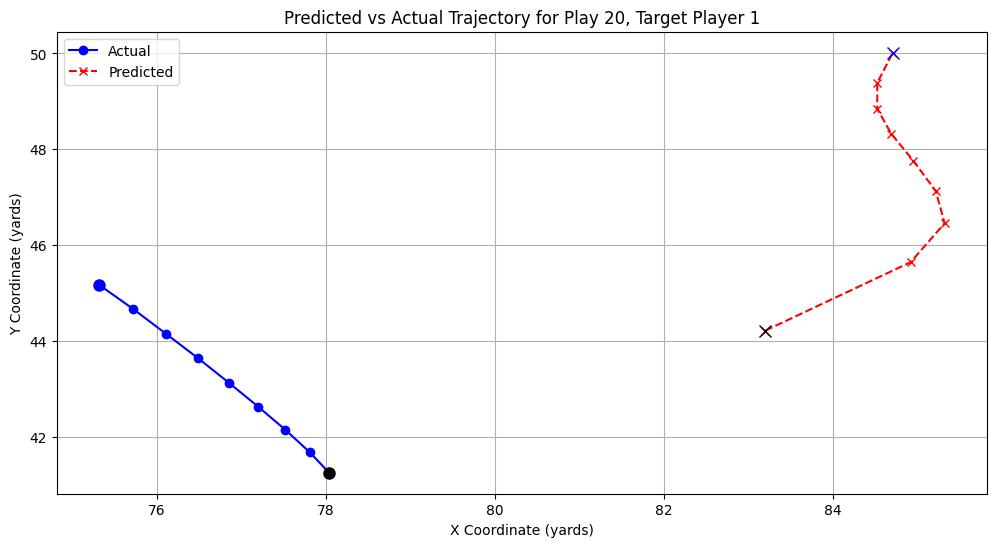

In [27]:
def visualize_predictions(model, data_loader, play_idx=0, target_player_idx=0):

    model.eval()

    with torch.no_grad():
        for batch_sequence, batch_targets, batch_masks, batch_start_pos, batch_input_lengths, batch_output_lengths, batch_player_pos in data_loader:
            batch_sequence = batch_sequence.to('cuda')
            batch_targets = batch_targets.to('cuda')
            batch_masks = batch_masks.to('cuda')
            batch_start_pos = batch_start_pos.to('cuda')
            batch_input_lengths = batch_input_lengths.to('cuda')
            batch_output_lengths = batch_output_lengths.to('cuda')
            batch_player_pos = batch_player_pos.to('cuda')

            with torch.autocast(device_type="cuda"):
                val_predictions = model(batch_sequence, batch_start_pos, batch_masks, batch_output_lengths,
                                        batch_input_lengths, target_seq = batch_targets, teacher_prob = 0,
                                        player_positions = batch_player_pos)

            predicted_trajectory = val_predictions[play_idx, target_player_idx, :, :].cpu().numpy()
            actual_trajectory = batch_targets[play_idx, target_player_idx, :, :].cpu().numpy()
            output_length = batch_output_lengths[play_idx].cpu().numpy()


            predicted_trajectory = predicted_trajectory[:output_length]
            actual_trajectory = actual_trajectory[:output_length]

            # scale back to normal
            predicted_trajectory[:, 0] *= 120
            predicted_trajectory[:, 1] *= 53.3
            actual_trajectory[:, 0] *= 120
            actual_trajectory[:, 1] *= 53.3

            # plot trajectory
            plt.figure(figsize=(12, 6))
            plt.plot(actual_trajectory[:, 0], actual_trajectory[:, 1], marker='o', linestyle='-', color='blue', label='Actual')
            plt.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], marker='x', linestyle='--', color='red', label='Predicted')
            plt.xlabel('X Coordinate (yards)')
            plt.ylabel('Y Coordinate (yards)')
            plt.title(f'Predicted vs Actual Trajectory for Play {play_idx}, Target Player {target_player_idx}')
            plt.legend()
            plt.grid(True)

            # first point in black
            plt.plot(actual_trajectory[0, 0], actual_trajectory[0, 1], marker='o', color='black', markersize=8)
            plt.plot(predicted_trajectory[0, 0], predicted_trajectory[0, 1], marker='x', color='black', markersize=8)

            # last point blue
            plt.plot(actual_trajectory[-1, 0], actual_trajectory[-1, 1], marker='o', color='blue', markersize=8)
            plt.plot(predicted_trajectory[-1, 0], predicted_trajectory[-1, 1], marker='x', color='blue', markersize=8)

            plt.show()

            break

visualize_predictions(model, test_loader, play_idx=20, target_player_idx=1)

In [ ]:
# Get a sample from the training dataset
sample_sequence, target_positions, target_mask, start_pos, input_length, output_length = train_dataset[0]

# Display the target masks
print("Target Masks:")
print(target_mask)

# Display the start positions
print("\nStart Positions:")
print(start_pos)

# Display the target positions
print("\nTarget Positions:")
print(target_positions)